<a href="https://colab.research.google.com/github/Prime-21/TensorFlow-Multiclass-Image-Classification-using-CNN/blob/main/prasad_kharat_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.utils as np_utils
# convert to one-hot-encoding

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
print(data_dir_train)

if data_dir_train.exists():
    print("The directory exists.")
else:
    print("The directory does not exist.")

data_dir_test = pathlib.Path('/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
print(data_dir_test)


/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train
The directory exists.
/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Create the training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [11]:

## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

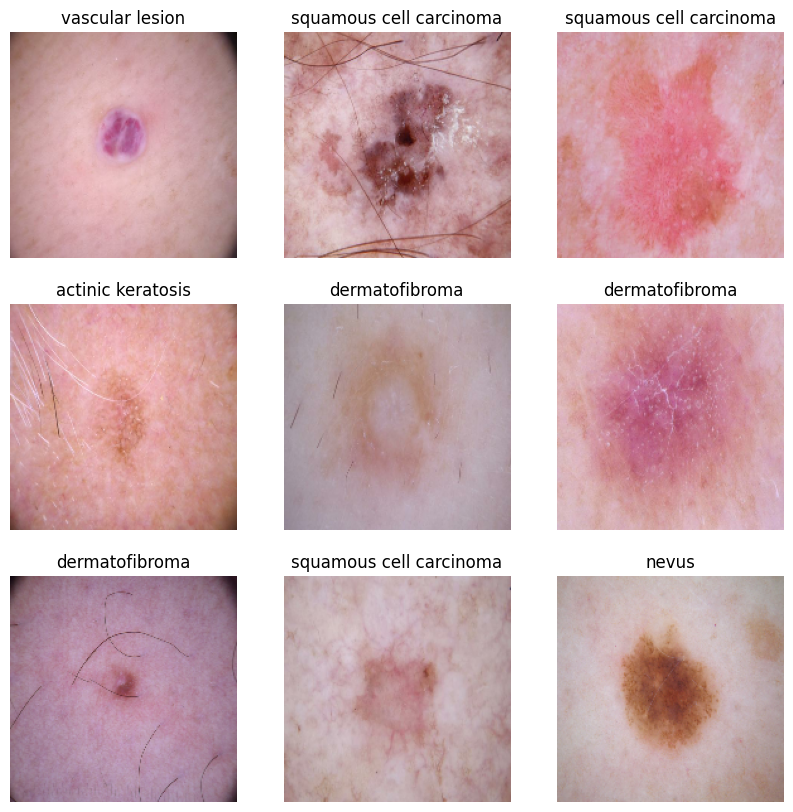

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [16]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

### Train the model

In [19]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 87s 108ms/step - loss: -5340698.0000 - accuracy: 0.1207 - val_loss: -16178487.0000 - val_accuracy: 0.1291
Epoch 2/20
281/281 [==============================] - 18s 65ms/step - loss: -67869024.0000 - accuracy: 0.1208 - val_loss: -155174912.0000 - val_accuracy: 0.1291
Epoch 3/20
281/281 [==============================] - 19s 67ms/step - loss: -273455712.0000 - accuracy: 0.1208 - val_loss: -554399040.0000 - val_accuracy: 0.1291
Epoch 4/20
281/281 [==============================] - 19s 67ms/step - loss: -693137600.0000 - accuracy: 0.1208 - val_loss: -1024632832.0000 - val_accuracy: 0.1291
Epoch 5/20
281/281 [==============================] - 19s 67ms/step - loss: -1367763200.0000 - accuracy: 0.1208 - val_loss: -2133559040.0000 - val_accuracy: 0.1291
Epoch 6/20
281/281 [==============================] - 19s 66ms/step - loss: -2342540544.0000 - accuracy: 0.1208 - val_loss: -2350224896.0000 - val_accuracy: 0.1291
Epoch 7/20
281/281 [======

### Visualizing training results

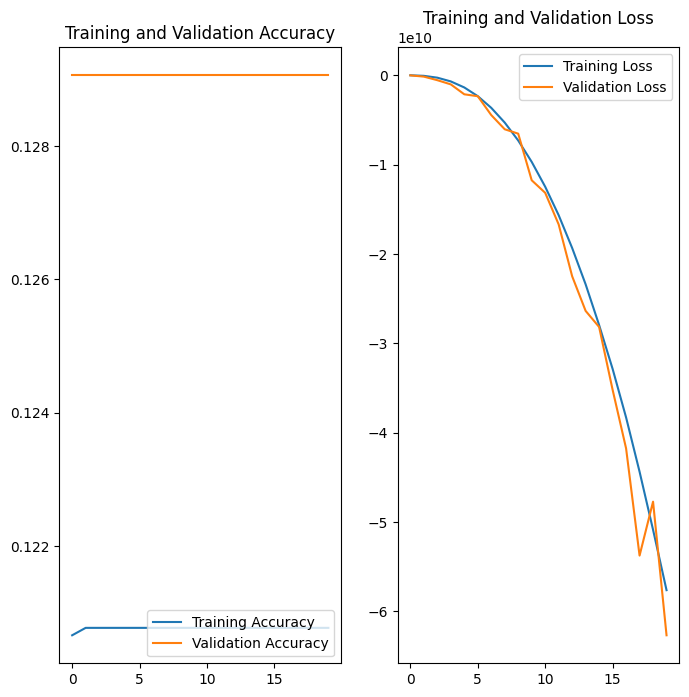

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Overfit or Underfit?

In [21]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

71/71 [==============================] - 1s 15ms/step - loss: -62692020224.0000 - accuracy: 0.1291
Accuracy:  0.12077402323484421
Validation Accuracy:  0.12906096875667572
Loss:  -62688358400.0
Validation Loss -62692020224.0


In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 3890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


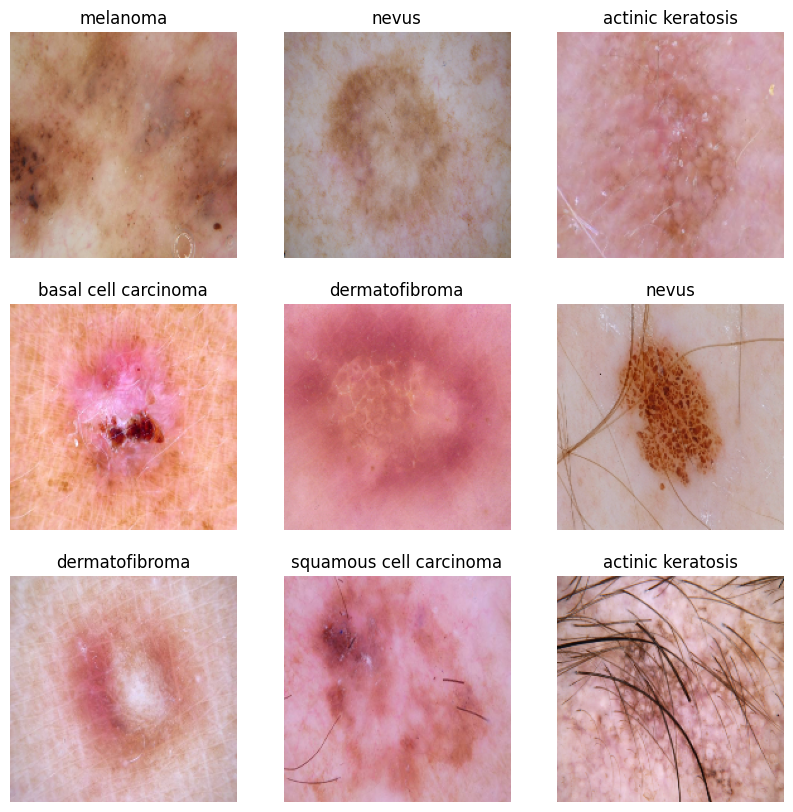

In [23]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Create the model, compile and train the model

In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.build(input_shape=(None, 180, 180, 3))
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_13 (ModuleW  (None, 180, 180, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_14 (ModuleW  (None, 180, 180, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_15 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_16 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_17 (ModuleW  (None, 90, 90, 64)       

### Compiling the model

In [25]:
## Your code goes here

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False) # Set a small value for epsilon
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.



In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])


Epoch 1/20
61/61 [==============================] - 96s 1s/step - loss: 57.5736 - accuracy: 0.4386 - val_loss: 1.7790 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 2/20
61/61 [==============================] - 75s 1s/step - loss: 0.8610 - accuracy: 0.5920 - val_loss: 1.1782 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 3/20
61/61 [==============================] - 76s 1s/step - loss: 0.7888 - accuracy: 0.6450 - val_loss: 1.0801 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 4/20
61/61 [==============================] - 76s 1s/step - loss: 0.7093 - accuracy: 0.6956 - val_loss: 1.0011 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/20
61/61 [==============================] - 76s 1s/step - loss: 0.6972 - accuracy: 0.7049 - val_loss: 1.0442 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/20
61/61 [==============================] - 75s 1s/step - loss: 0.6952 - accuracy: 0.6943 - val_loss: 1.0956 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 7/20
61/61 [==============================] - ETA: 0s - loss: 0.6842 - accu

### Visualizing the results

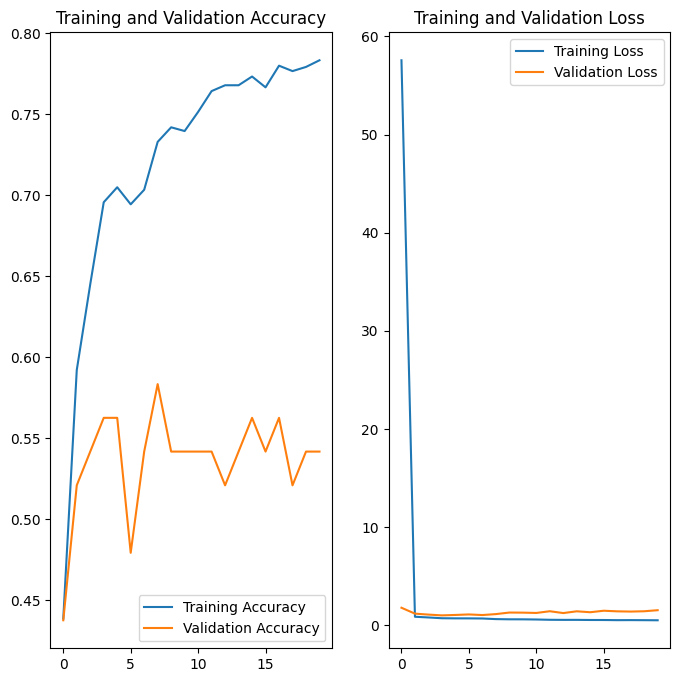

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
# Now evaluate your model using the encoded labels
loss, accuracy = model.evaluate(train_ds, verbose=1)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

99/99 [==============================] - 16s 153ms/step - loss: 0.0000e+00 - accuracy: 0.1252
Accuracy:  0.11769377440214157
Validation Accuracy:  0.1251986026763916
Loss:  0.0
Validation Loss 0.0


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

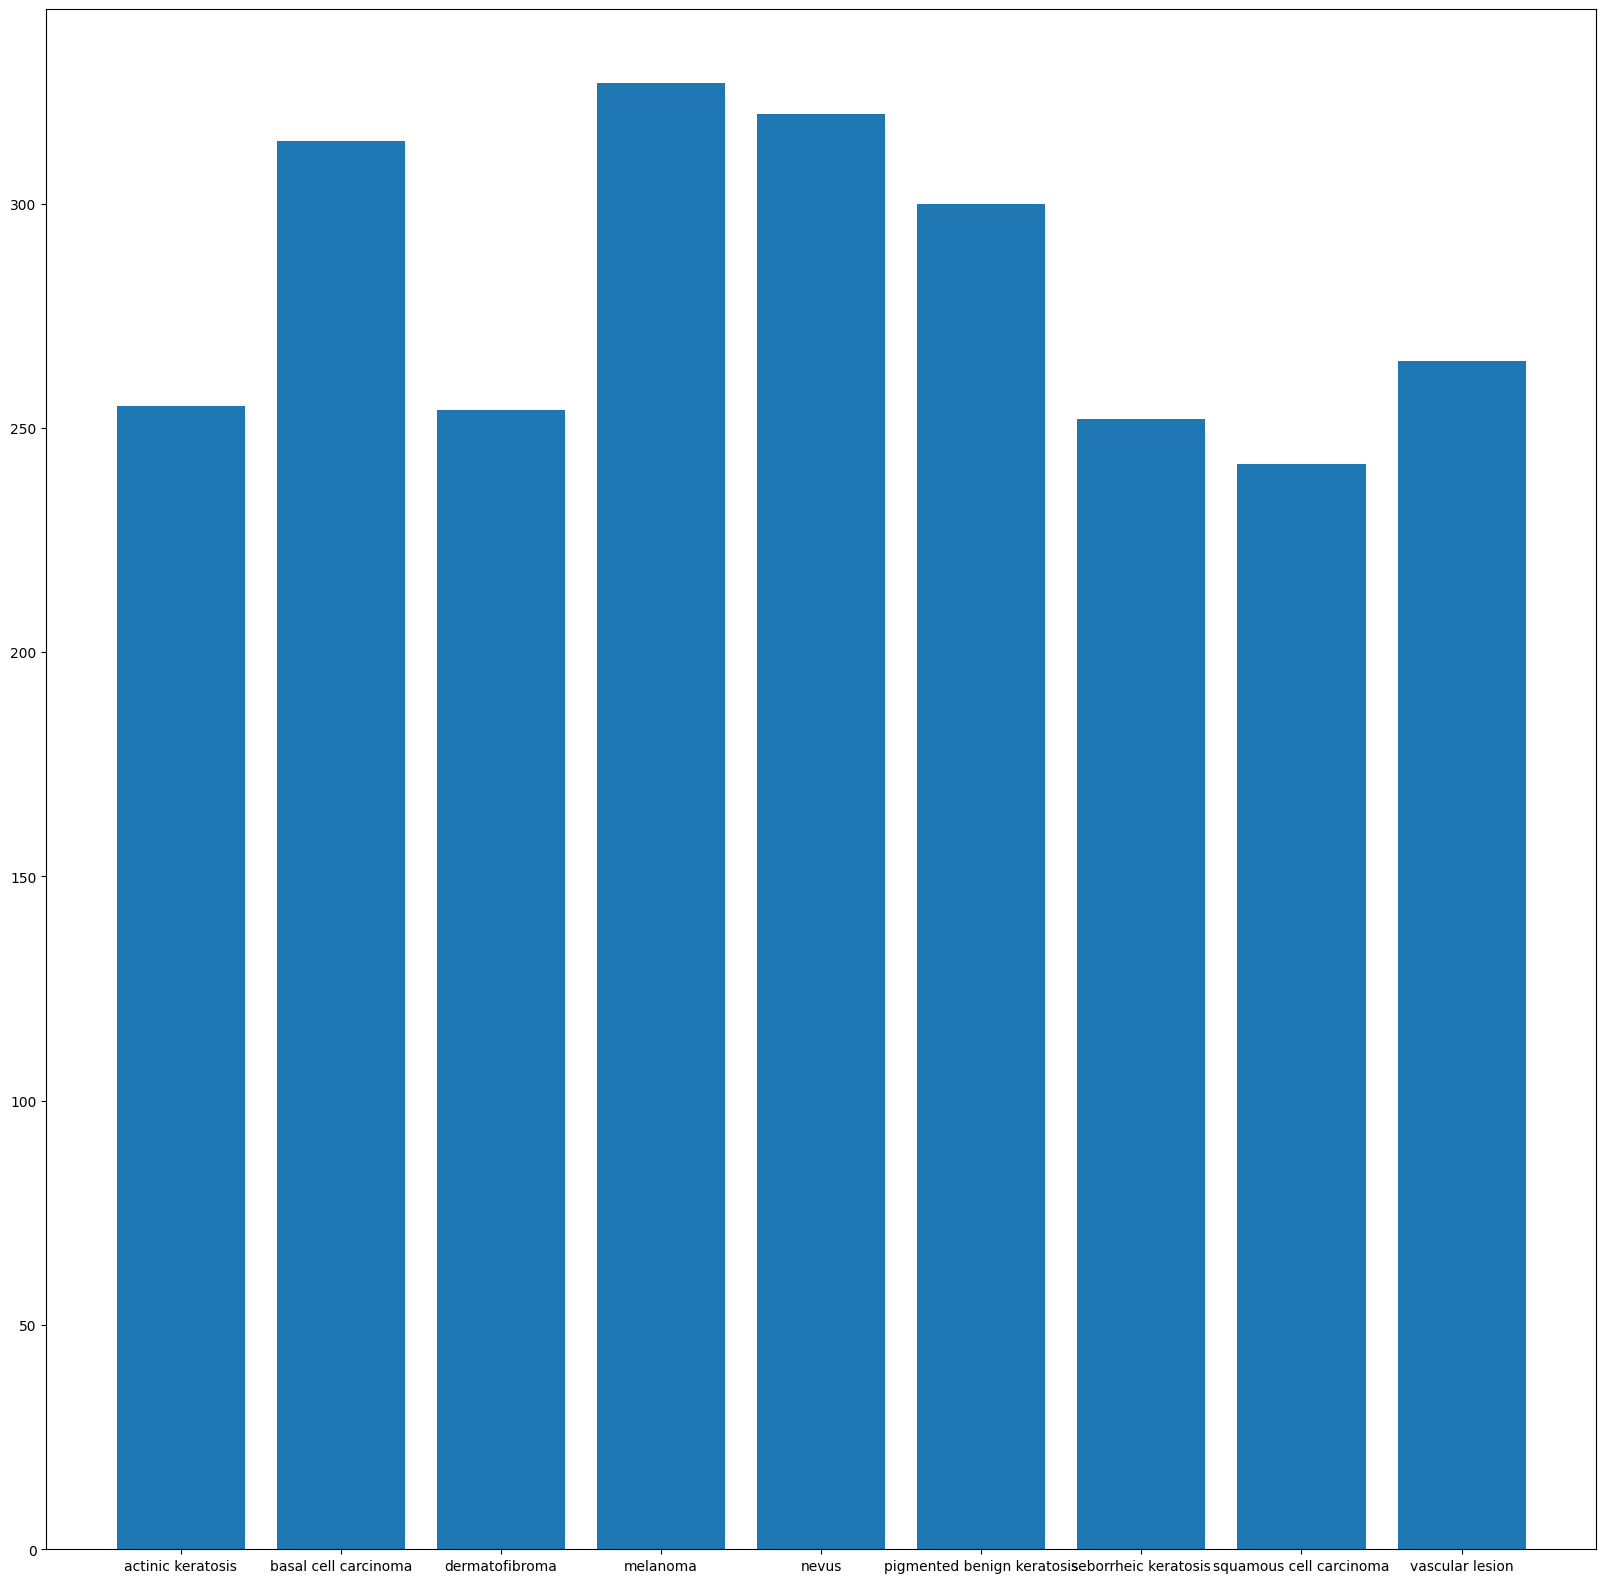

In [32]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.
- Which class has the least number of samples? - Actinic Keratosos and Seborrheic keratosis
- Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis dominates the data of count more than 100 in training

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset="/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CC85FD1C60>: 100%|██████████| 500/500 [00:25<00:00, 19.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CC85026590>: 100%|██████████| 500/500 [00:21<00:00, 22.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CC85E62980>: 100%|██████████| 500/500 [00:20<00:00, 23.88 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79CC85494490>: 100%|██████████| 500/500 [01:36<00:00,  5.21 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x79CC85365960>: 100%|██████████| 500/500 [01:12<00:00,  6.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79CC82390F10>: 100%|██████████| 500/500 [00:19<00:00, 26.03 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79CC8571A050>: 100%|██████████| 500/500 [00:39<00:00, 12.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CC851B4040>: 100%|██████████| 500/500 [00:18<00:00, 27.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CC85494490>: 100%|██████████| 500/500 [00:20<00:00, 24.27 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
import os
from glob import glob  # Import the glob function

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010023.jpg_2c2e409f-0a1b-4105-8af8-719302adc28d.jpg',
 '/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000142.jpg_24cd94f0-a79f-4ed6-9dec-e227f6473e9c.jpg',
 '/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010392.jpg_6ef2828f-4b4b-4460-9031-6df2059e6048.jpg',
 '/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [40]:
new_df['Label'].value_counts()

Label
melanoma                      1500
basal cell carcinoma          1500
vascular lesion               1500
seborrheic keratosis          1500
nevus                         1500
actinic keratosis             1500
pigmented benign keratosis    1500
squamous cell carcinoma       1500
dermatofibroma                1500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
data_dir_train="/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/TensorFlow-Multiclass-Image-Classification-using-CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### Create your model (make sure to include normalization)

In [44]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.build(input_shape=(None, 180, 180, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_28 (ModuleW  (None, 180, 180, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_29 (ModuleW  (None, 180, 180, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_30 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 batch_normalization_2 (Bat  (None, 90, 90, 32)        128       
 chNormalization)                                                
                                                                 
 module_wrapper_31 (ModuleW  (None, 90, 90, 32)       

#### Compile your model (Choose optimizer and loss function appropriately)

In [45]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)


In [46]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',   # Monitor validation accuracy
    patience=3,               # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,                # Print a message for each reduction
    factor=0.5,               # Factor by which the learning rate will be reduced
    min_lr=0.00001            # Lower bound on the learning rate
)


#### Train your model

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

epochs = 50
batch_size = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[learning_rate_reduction]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


394/394 [==============================] - 108s 248ms/step - loss: 0.0000e+00 - accuracy: 0.1177 - val_loss: 0.0000e+00 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 2/50
394/394 [==============================] - 93s 232ms/step - loss: 0.0000e+00 - accuracy: 0.1177 - val_loss: 0.0000e+00 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 3/50
394/394 [==============================] - 98s 245ms/step - loss: 0.0000e+00 - accuracy: 0.1177 - val_loss: 0.0000e+00 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 4/50
394/394 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1177
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
394/394 [==============================] - 97s 243ms/step - loss: 0.0000e+00 - accuracy: 0.1177 - val_loss: 0.0000e+00 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 5/50
394/394 [==============================] - 94s 235ms/step - loss: 0.0000e+00 - accuracy: 0.1177 - val_loss: 0.0000e+00 - val_accuracy: 0.1252 - lr: 5.0000e-04
Epoch 6/50


#### **Todo:**  Visualize the model results

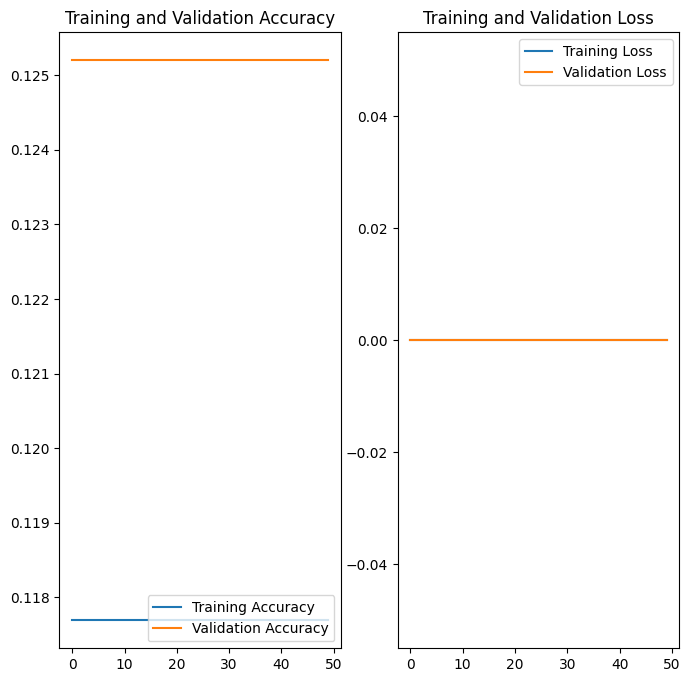

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

Then we introduced dropout and ImageDataGenerator which reduced the over fit

At last we tried Batch Normalization and Augumentation which really helped in carry forward